In [6]:
setwd("/frazer01/projects/CARDIPS/analysis/cardiac_eqtls")

source("script/packages.R"  )
source("script/input_data.R")
source("script/functions.R" )

dir.create("pipeline/4.13.heart_failure/cell_type", showWarnings = FALSE)


# Input CVPC + adult

In [7]:
metadata   =              fread("pipeline/3.1.covariates/metadata.txt"     , sep = "\t", header = TRUE , data.table = FALSE)
covariates = add_rownames(fread("pipeline/3.1.covariates/covariates.txt"   , sep = "\t", header = TRUE , data.table = FALSE))
int_list   = readLines         ("pipeline/3.2.eqtls/vars/cardiac_eqtls.txt")
#int_list   = int_list[grepl("^peer", int_list) == FALSE & grepl("^pc", int_list) == FALSE] # original
int_list   = c("sex", "total_reads_norm") # remove mitochondrial reads as covariate
covariates = covariates[,int_list]
gene_tpm   = add_rownames(fread("pipeline/1.2.expression/tpm_gene.normalized.txt"   , sep = "\t", header = TRUE , data.table = FALSE))
isof_tpm   = add_rownames(fread("pipeline/1.2.expression/tpm_isoform.normalized.txt", sep = "\t", header = TRUE , data.table = FALSE))
isof_use   = add_rownames(fread("pipeline/1.2.expression/use_isoform.normalized.txt", sep = "\t", header = TRUE , data.table = FALSE))


In [8]:

gene_info               = fread("input/phenotypes/gene_info.txt"   , sep = "\t", header = TRUE, data.table = FALSE)
isof_info               = fread("input/phenotypes/isoform_info.txt", sep = "\t", header = TRUE, data.table = FALSE)
gene_info$transcript_id = gene_info$gene_id

diffgene = fread(paste("pipeline/4.1.differential_expression", "diffexp.txt"     , sep = "/"), sep = "\t", header = TRUE, data.table = FALSE)
diffcell = fread(paste("pipeline/4.1.differential_expression", "diffexp_cell.txt", sep = "/"), sep = "\t", header = TRUE, data.table = FALSE)

diffgene$diffexp = FALSE
diffgene[diffgene$qval < 0.05, "diffexp"] = TRUE


# Input heart failure

In [38]:
meta4            = fread("/frazer01/projects/CARDIPS/analysis/heart_failure_gene_expression/input/phenotypes/SraRunTable_GSE46224.txt", sep = "\t", header = TRUE, data.table = FALSE)
colnames(meta4)  = tolower(gsub(" ", "_", colnames(meta4)))
meta4            = meta4[,c("run", "name", "age", "sex", "lvad_support")]
meta4$subject_id = gsub("_LVAD", "", meta4$name)

meta4 = meta4[!meta4$run %in% c("SRR830992", "SRR830976"),]
meta4$hf = 0
meta4[ meta4$lvad_support == "pre-LVAD", "hf"] = 1

gene_tpm_hf   = add_rownames(fread("/frazer01/projects/CARDIPS/analysis/heart_failure_gene_expression/pipeline/1.2.expression/tpm_gene.normalized.txt"  , sep = "\t", header = TRUE , data.table = FALSE))
isof_use_hf   = add_rownames(fread("/frazer01/projects/CARDIPS/analysis/heart_failure_gene_expression/pipeline/1.2.expression/use_isoform.expressed.txt", sep = "\t", header = TRUE , data.table = FALSE))

gene_tpm_hf   = gene_tpm_hf[,meta4$run]
isof_use_hf   = isof_use_hf[,meta4$run]

meta4       = meta4[ meta4$lvad_support != "nil",]
gene2sd     = data.frame(gene_id = rownames(gene_tpm_hf), sd = unlist(apply(gene_tpm_hf, 1, sd)), median = unlist(apply(gene_tpm_hf, 1, median)))
isof2sd     = data.frame(gene_id = rownames(isof_use_hf), sd = unlist(apply(isof_use_hf, 1, sd)), median = unlist(apply(isof_use_hf, 1, median)))
gene_tpm_hf = gene_tpm_hf[rownames(gene_tpm_hf) %in% gene2sd[ gene2sd$sd > 0, "gene_id"],]
isof_use_hf = isof_use_hf[rownames(isof_use_hf) %in% isof2sd[ isof2sd$sd > 0 & isof2sd$median > 0 & isof2sd$median < 100, "gene_id"],]


[1] 20271

In [39]:
cibersort_hf  = add_rownames(fread("/frazer01/projects/CARDIPS/analysis/heart_failure_gene_expression/pipeline/2.1.scrna_seq/cibersort.new.txt", sep = "\t", header = TRUE, data.table = FALSE))
flagstat_hf   = add_rownames(fread("/frazer01/projects/CARDIPS/analysis/heart_failure_gene_expression/input/phenotypes/combined/flagstat.txt"  , sep = "\t", header = TRUE, data.table = FALSE))

cibersort_hf[,c("P-value", "Correlation", "RMSE")] = NULL
colnames(cibersort_hf) = gsub("_cell", "", colnames(cibersort_hf))
cell2color_hf          = data.frame(cell_type = colnames(cibersort_hf), color = c("#bb0000", "#00bb00", "#ff8888", "#FF34B3", "#0000bb", "#cdcd00", "#3D3D3D", "#8B814C")) 
cibersort_hf           = cibersort_hf[ meta4$run,]


covariates_hf = add_rownames(merge(cibersort_hf , flagstat_hf, by = "row.names"))
covariates_hf = add_rownames(merge(covariates_hf, meta4[,c("run", "sex", "age", "hf")], by.x = "row.names", by.y = "run"))
                                                        

covariates_hf$total_reads_norm                              = covariates_hf$total_reads / mean(covariates_hf$total_reads)
covariates_hf$uniquely_mapped_reads_to_canonical_chromsomes = rowSums(covariates_hf[,c("autosomal_reads", "chrX_reads", "chrY_reads")]) / covariates_hf$total_reads
covariates_hf$mitochondrial_reads                           = covariates_hf$chrM_reads / covariates_hf$total_reads

covariates_hf = covariates_hf[,c(cell2color_hf$cell_type, "total_reads_norm", "uniquely_mapped_reads_to_canonical_chromsomes", "mitochondrial_reads", "sex", "age")]

covariates_hf$sex = as.numeric(suppressMessages(mapvalues(covariates_hf$sex, from=c("male", "female"), to = 0:1)))


# Differential expression by cell type

In [41]:
run_diffexp_lm = function(gene_id, x, covariates, vars0, var1)
{
	covariates$exp    = as.numeric(x[gene_id, rownames(covariates)])
	mylm              = as.data.frame(coefficients(summary(lm(exp ~ ., data = covariates[, c("exp", var1, vars0)]))))
	out               = mylm[var1, ]
	colnames(out)     = c("beta", "se", "tval", "pval")
	out$cell_type     = var1
	out$transcript_id = gene_id
	
	return(out)
}

run_diffexp = function(x, name, metadata, covariates, tissue1, tissue2)
{
	message(name)
	
	runs              = intersect(metadata$run, rownames(covariates))
	metadata          = metadata  [metadata$run %in% runs,]
	covariates        = covariates[runs,]
	x                 = x[, rownames(covariates)]
	vars0             = c("sex", "age", "total_reads_norm", "uniquely_mapped_reads_to_canonical_chromsomes", "mitochondrial_reads") # original
	vars1             = cell2color_hf$cell_type
	diffexp           = as.data.frame(rbindlist(lapply(rownames(x), function(gene_id)
	{
		as.data.frame(rbindlist(lapply(vars1, function(var1)
		{
			run_diffexp_lm(gene_id, x, covariates, vars0, var1)
		})), stringsAsFactors = FALSE)
	})), stringsAsFactors = FALSE)
	
	diffexp$qval      = p.adjust(diffexp$pval, method = "bonferroni") 
    diffexp$name      = name
    
	fwrite(diffexp, paste("pipeline/4.13.heart_failure/cell_type", paste("diffexp_cell", name, "txt", sep = "."), sep = "/"), sep = "\t", col.names = TRUE, row.names = FALSE)
}

run_diffexp(gene_tpm_hf, "all.gene_tpm"    , meta4                 , covariates_hf)
run_diffexp(isof_use_hf, "all.isoform_use" , meta4                 , covariates_hf)
run_diffexp(gene_tpm_hf, "pre.gene_tpm"    , meta4[ meta4$hf == 1,], covariates_hf)
run_diffexp(gene_tpm_hf, "post.gene_tpm"   , meta4[ meta4$hf == 0,], covariates_hf)
run_diffexp(isof_use_hf, "pre.isoform_use" , meta4[ meta4$hf == 1,], covariates_hf)
run_diffexp(isof_use_hf, "post.isoform_use", meta4[ meta4$hf == 0,], covariates_hf)


all.gene_tpm

all.isoform_use

pre.gene_tpm

post.gene_tpm

pre.isoform_use

post.isoform_use



In [42]:
diffexp2read = list.files("pipeline/4.13.heart_failure/cell_type", pattern = "^diffexp_cell\\.", full.names = TRUE)

diffexp = as.data.frame(rbindlist(lapply(diffexp2read, function(x){fread(x, sep = "\t", header = TRUE, data.table = FALSE)})), stringsAsFactors = FALSE)

diffexp$diffexp = FALSE
diffexp[diffexp$qval < 0.1, "diffexp"] = TRUE

diffexp$type = unlist(lapply(diffexp$name, function(x){unlist(strsplit(x, "\\."))[[2]]}))
diffexp$name = unlist(lapply(diffexp$name, function(x){unlist(strsplit(x, "\\."))[[1]]}))


gene_tpm endothelial -0.0296091004947378 2.48346159557041e-05

gene_tpm leukocyte 0.184348338619639 2.01580084025764e-154

gene_tpm fibroblast 0.275668763091554 0

gene_tpm myofibroblast -0.0658553790887204 6.24086689509028e-21

gene_tpm endocardial 0.129893641424661 5.48016865555281e-77

gene_tpm cardiac_muscle 0.259059331238267 3.74280843316903e-308

gene_tpm cardiac_neuron 0.198967447098093 4.62736733330882e-180

gene_tpm smooth_muscle 0.201856940754827 2.22947121225437e-185

isoform_use endothelial -0.0642550894154502 3.50002703772652e-28

isoform_use leukocyte -0.00654278729745449 0.262825868610487

isoform_use fibroblast 0.0404689413187552 4.24888855605749e-12

isoform_use myofibroblast -0.00736394625505818 0.207570445476224

isoform_use endocardial -0.003432283802349 0.556935917783552

isoform_use cardiac_muscle 0.0162286161455896 0.00547738991636445

isoform_use cardiac_neuron 0.00871217452513593 0.135956330537842

isoform_use smooth_muscle 0.00851685757642119 0.144953175190359

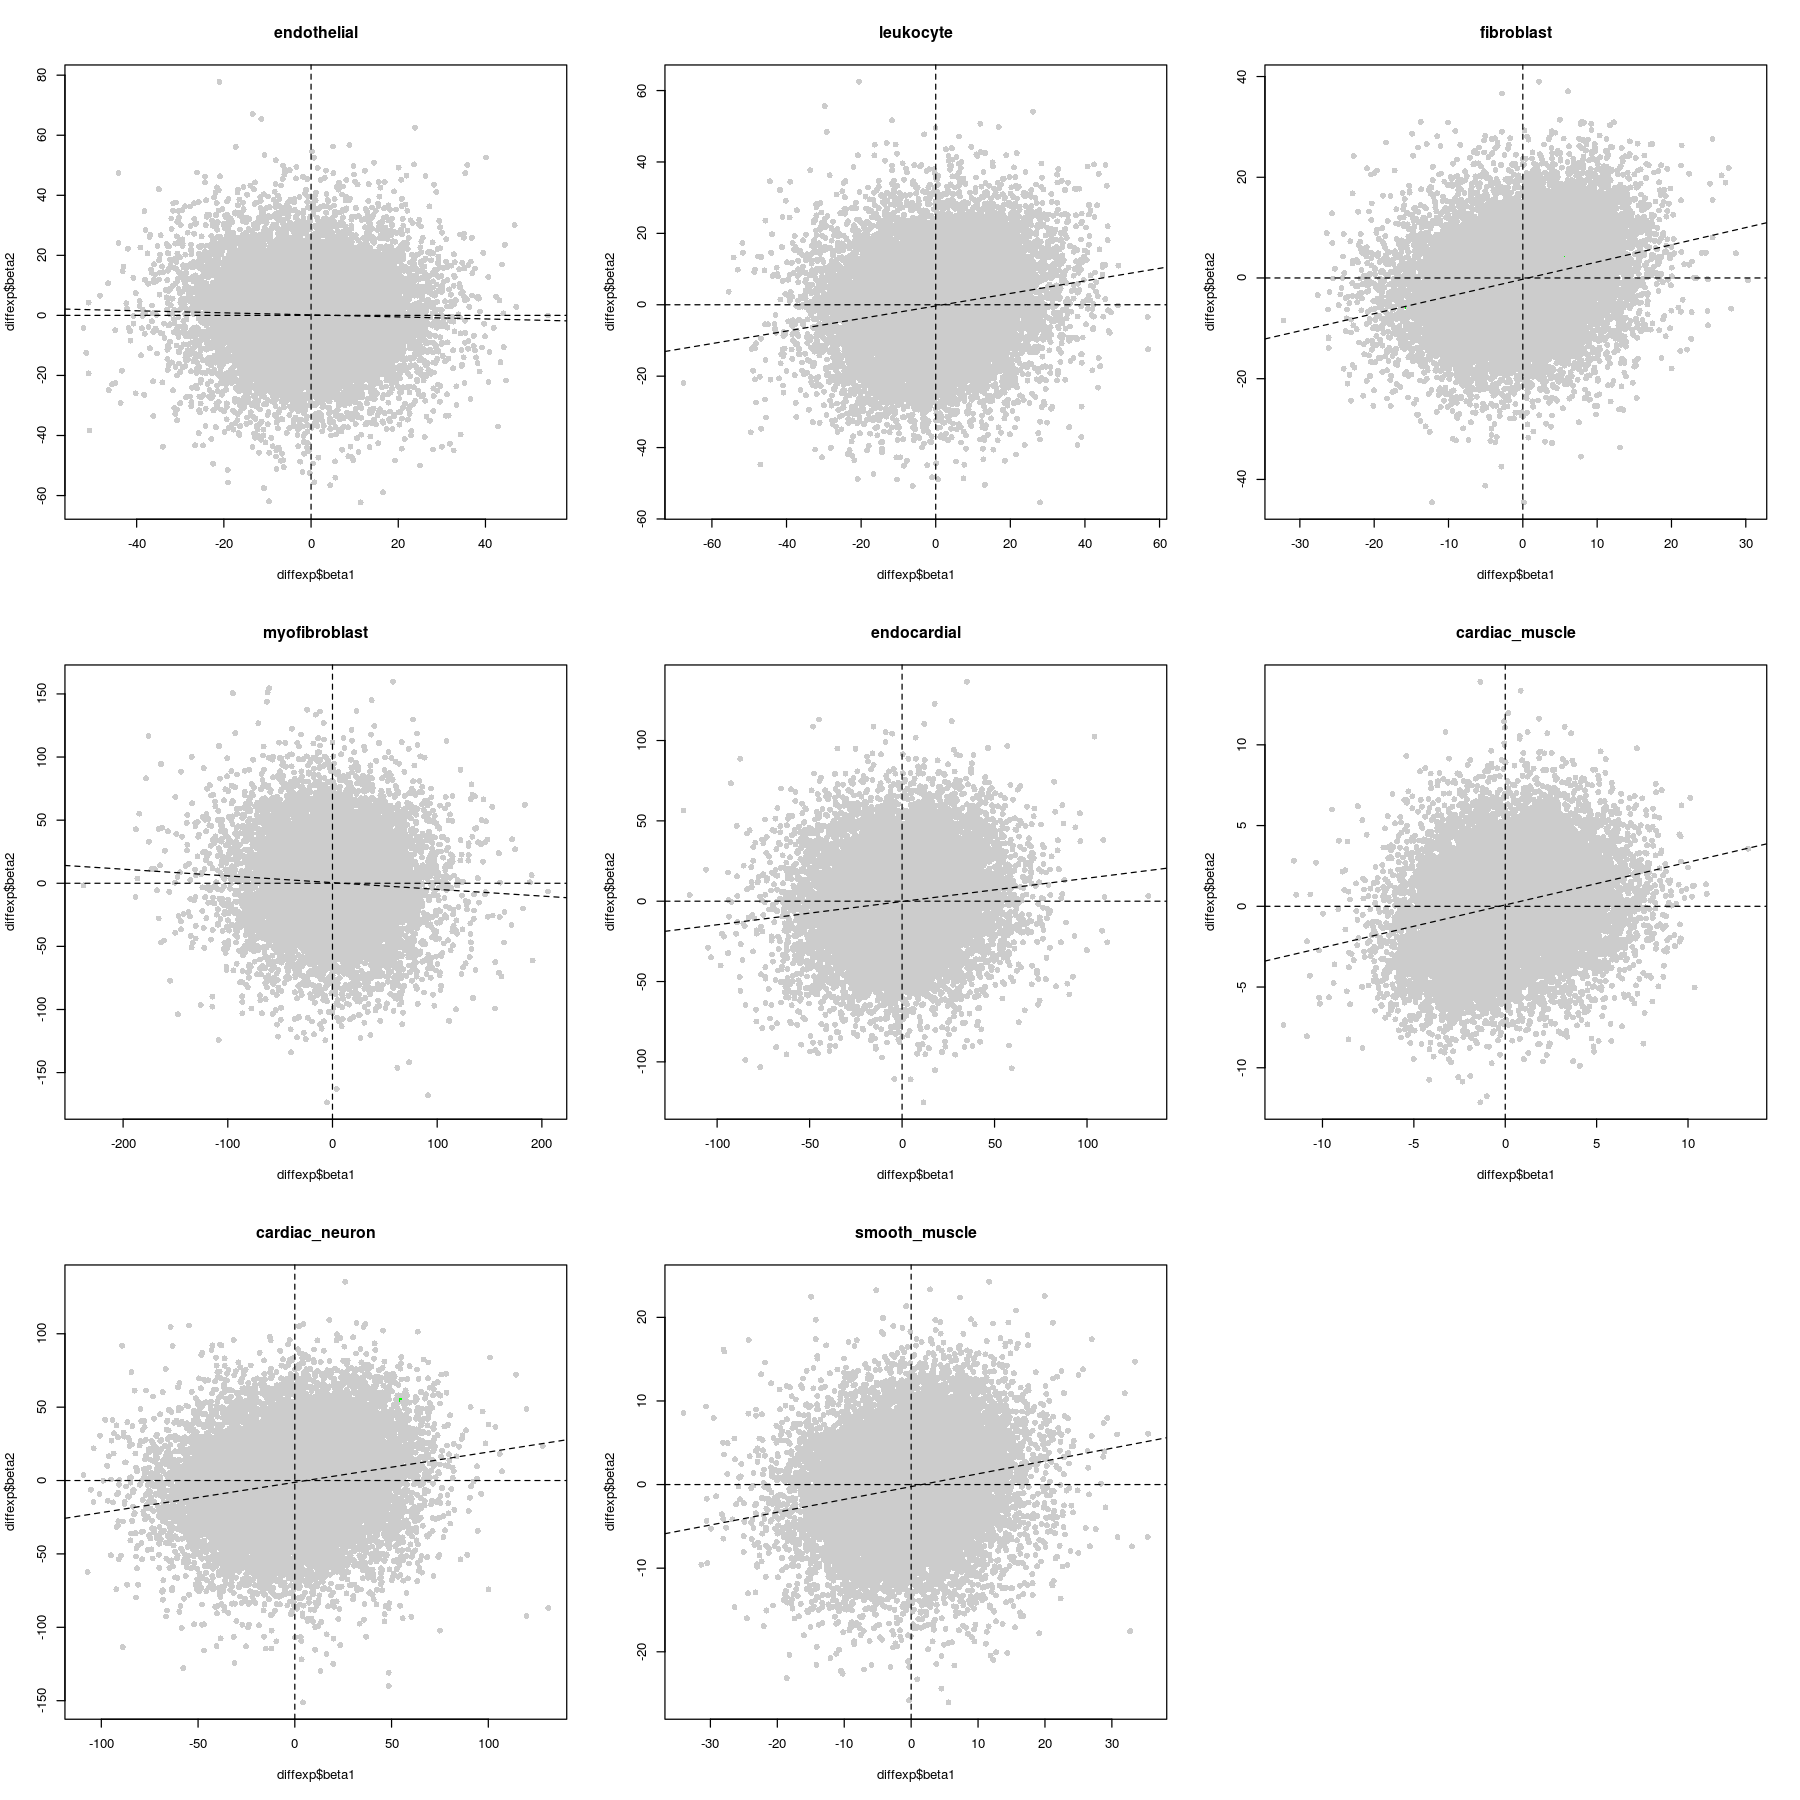

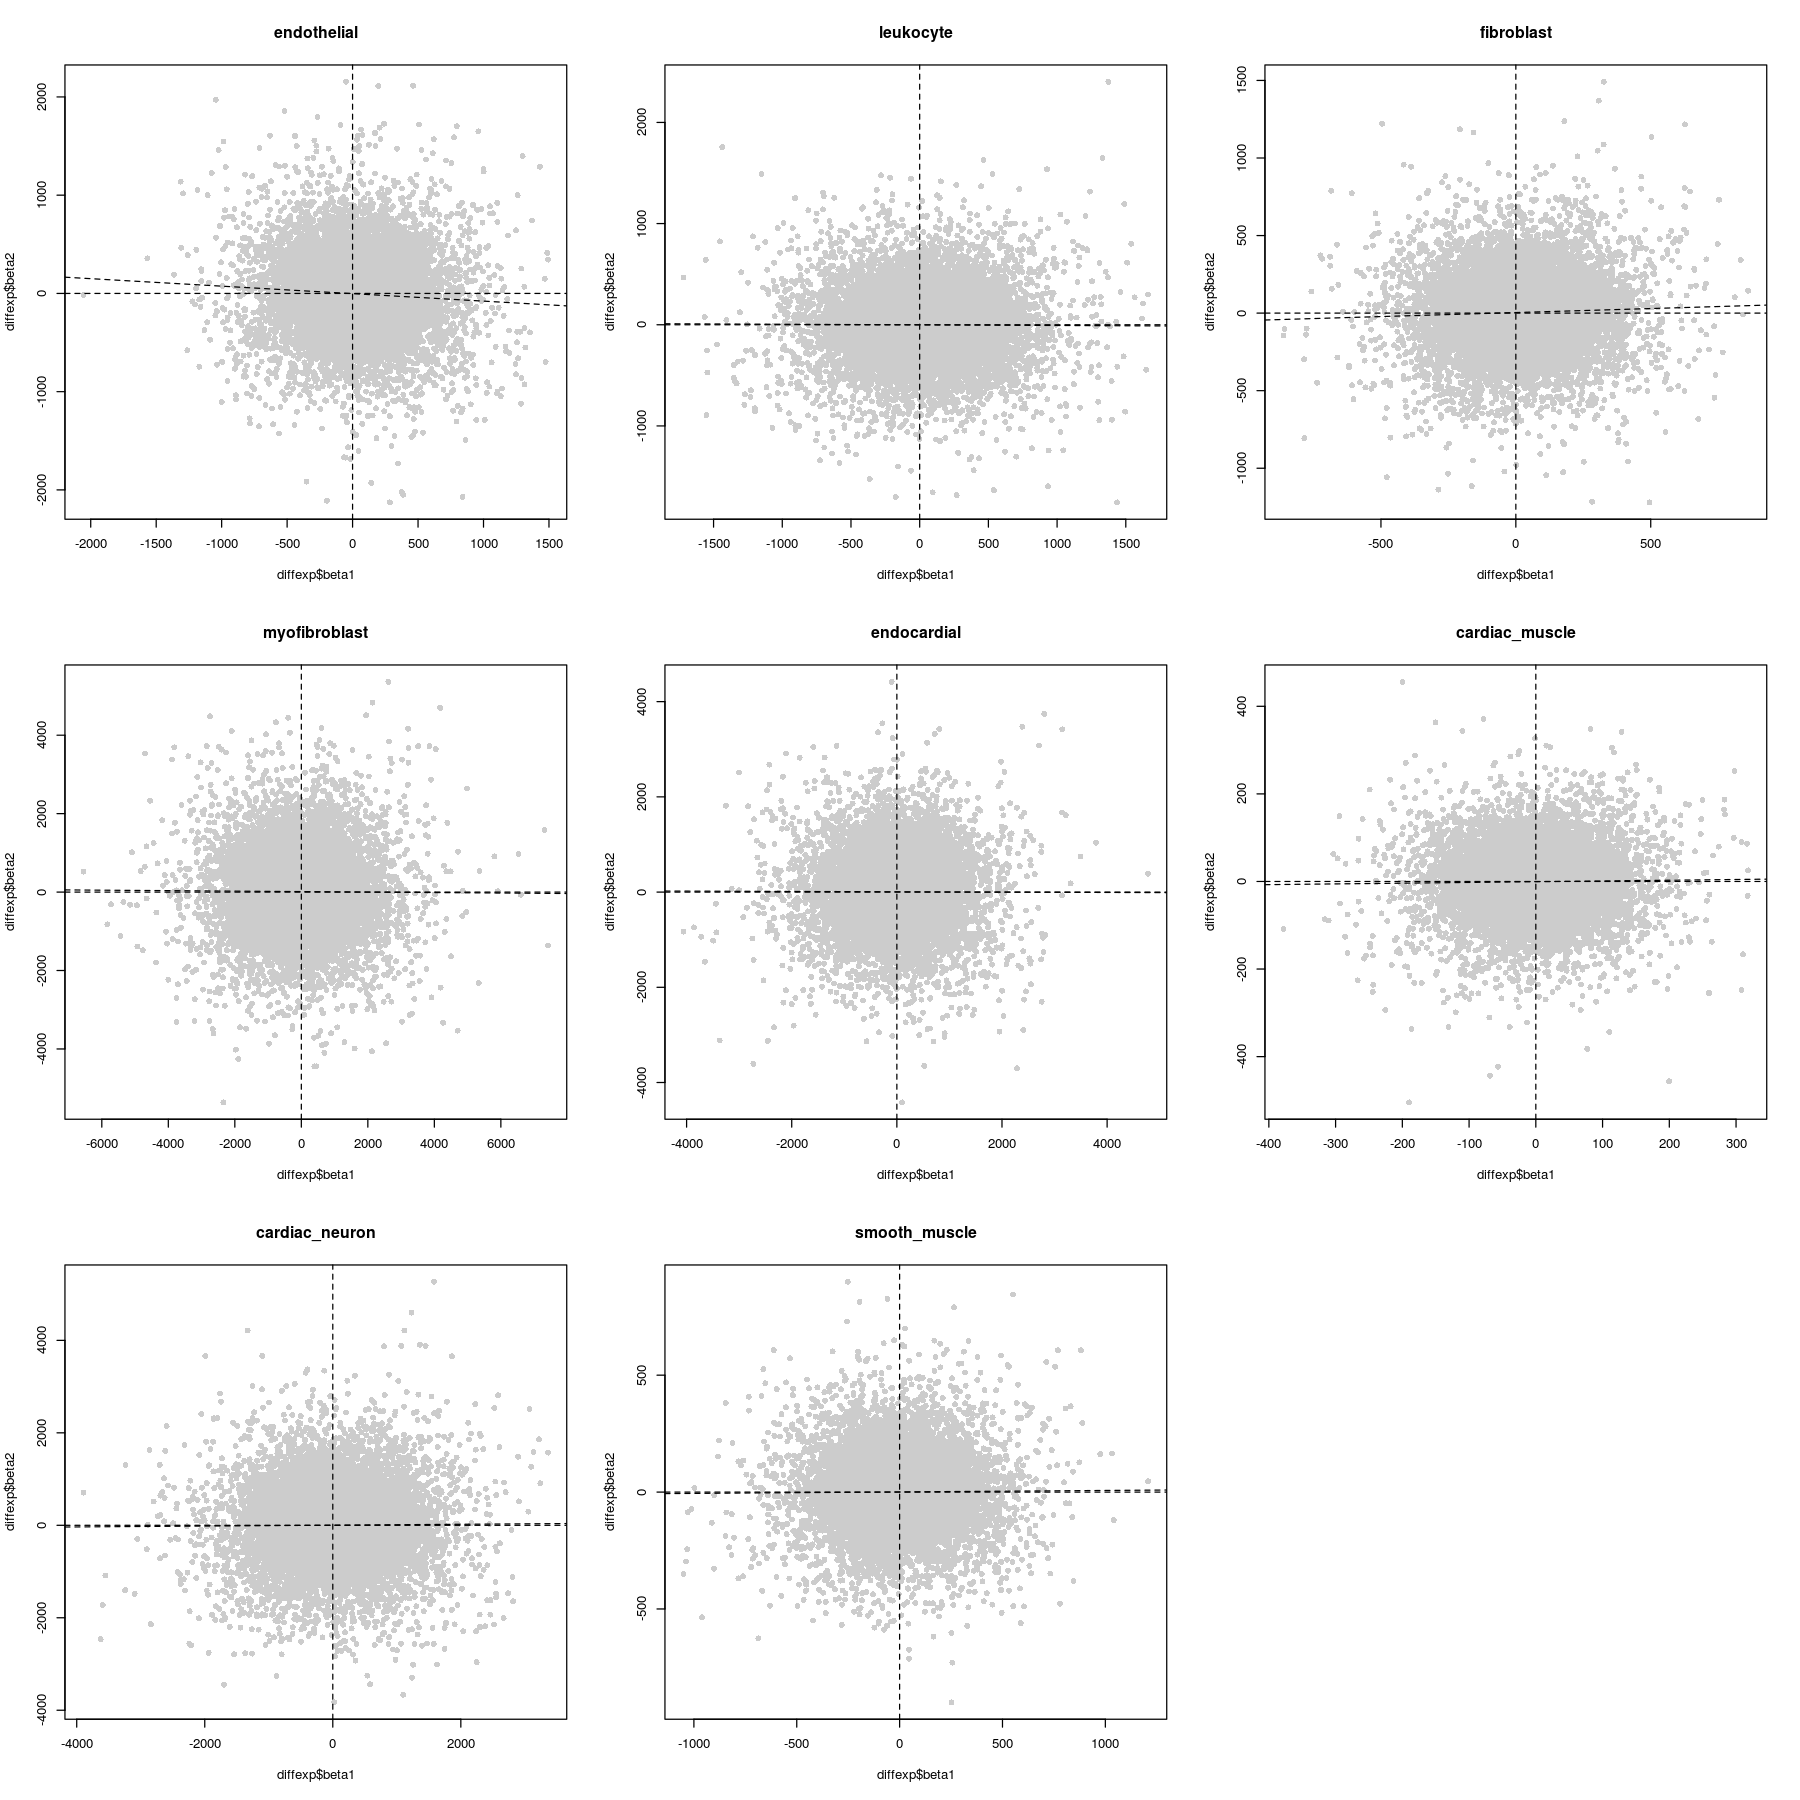

In [51]:
cor_diffexp_cell = function(cell, type, diffexp)
{
    this = diffexp[diffexp$cell_type == cell & diffexp$type == type,]
    
    x1 = this[this$name == "pre" ,]
    x2 = this[this$name == "post",]
    diffexp  = merge(x1[,c("transcript_id", "beta", "pval", "qval", "diffexp")], x2[,c("transcript_id", "beta", "pval", "qval", "diffexp")], by = "transcript_id", suffixes = 1:2)
    
    diffexp$color = "#cccccc"
    
    diffexp[ diffexp$diffexp1 == TRUE  & diffexp$diffexp1 == TRUE & sign(diffexp$beta1) == sign(diffexp$beta2), "color"] = "#00ff00"
    diffexp[ diffexp$diffexp1 == TRUE  & diffexp$diffexp1 == TRUE & sign(diffexp$beta1) != sign(diffexp$beta2), "color"] = "#ff0000"
    diffexp[ diffexp$diffexp1 == TRUE  & diffexp$diffexp1 == FALSE, "color"] = "#0000ff"
    diffexp[ diffexp$diffexp1 == FALSE & diffexp$diffexp1 == TRUE , "color"] = "#00ffff"
    diffexp[ diffexp$diffexp1 == FALSE & diffexp$diffexp1 == FALSE, "color"] = "#cccccc"
    
    plot(diffexp$beta1, diffexp$beta2, col = diffexp$color, pch = 16, main = cell)
    
    abline(v = 0, lty = "dashed")
    abline(h = 0, lty = "dashed")
    abline(lm(beta2 ~ beta1, data = diffexp), lty = "dashed")
    
    mycor = cor.test(diffexp$beta1, diffexp$beta2)
    
    #diffexp = diffexp[is.infinite(diffexp$log2r) == FALSE,]
    
    #mycor = cor.test(diffexp$log2r, diffexp$beta_ridge)
    
    message(paste(type, cell, mycor$estimate, mycor$p.value))
    
    return(table(diffexp[,c("diffexp1", "diffexp2")]))
}

options(repr.plot.width = 15, repr.plot.height = 15)
layout(matrix(1:9, nrow = 3, byrow = TRUE))
invisible(lapply(cell2color_hf$cell_type, function(cell){cor_diffexp_cell(cell, "gene_tpm"   , diffexp)}))

plot.new()

invisible(lapply(cell2color_hf$cell_type, function(cell){cor_diffexp_cell(cell, "isoform_use", diffexp)}))


In [54]:
diffexp_all = merge(diffexp[diffexp$name == "pre" , c("transcript_id", "cell_type", "type", "beta", "pval", "qval", "diffexp")], 
                    diffexp[diffexp$name == "post", c("transcript_id", "cell_type", "type", "beta", "pval", "qval", "diffexp")], by = c("transcript_id", "cell_type", "type"), suffixes = c("_pre", "_post"))

fwrite(diffexp_all, "pipeline/4.13.heart_failure/cell_type/diffexp_cell_pre_vs_post.txt", sep = "\t", col.names = TRUE, row.names = FALSE)

In [56]:
a = diffexp_all[ diffexp_all$diffexp_pre == TRUE | diffexp_all$diffexp_post == TRUE,]
a[order(a$beta_pre, decreasing = TRUE),]

,transcript_id,cell_type,type,beta_pre,pval_pre,qval_pre,diffexp_pre,beta_post,pval_post,qval_post,diffexp_post
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<lgl>
40258,ENSG00000126603.8_2,cardiac_neuron,gene_tpm,54.658750,2.583052e-07,0.04188883,TRUE,54.589459,1.840280e-02,1.00000000,FALSE
151925,ENSG00000272620.2_7,fibroblast,gene_tpm,5.513346,3.743524e-07,0.06070798,TRUE,4.732627,6.362826e-02,1.00000000,FALSE
35190,ENSG00000120265.18_7,leukocyte,gene_tpm,-7.278525,5.940284e-02,1.00000000,FALSE,-13.963252,1.135300e-07,0.01841093,TRUE
64405,ENSG00000152242.11_7,fibroblast,gene_tpm,-15.459878,1.910821e-07,0.03098740,TRUE,-5.875419,3.679665e-01,1.00000000,FALSE
2490,ENSG00000014824.14_5,cardiac_neuron,gene_tpm,-57.590090,6.141470e-07,0.09959499,TRUE,-6.104978,7.883968e-01,1.00000000,FALSE


In [52]:
str(diffexp)

'data.frame':	1189488 obs. of  10 variables:
 $ beta         : num  10.91 20.35 15.54 14.75 4.21 ...
 $ se           : num  7.94 9.24 4.9 23.36 17.21 ...
 $ tval         : num  1.374 2.203 3.171 0.631 0.245 ...
 $ pval         : num  0.18261 0.03785 0.00427 0.53395 0.80877 ...
 $ cell_type    : chr  "endothelial" "leukocyte" "fibroblast" "myofibroblast" ...
 $ transcript_id: chr  "ENSG00000227232.5_3" "ENSG00000227232.5_3" "ENSG00000227232.5_3" "ENSG00000227232.5_3" ...
 $ qval         : num  1 1 1 1 1 1 1 1 1 1 ...
 $ name         : chr  "all" "all" "all" "all" ...
 $ diffexp      : logi  FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ type         : chr  "gene_tpm" "gene_tpm" "gene_tpm" "gene_tpm" ...


In [58]:
gene_tpm_hf["ENSG00000126603.8_2",]

,SRR830989,SRR830990,SRR830991,SRR830993,SRR830994,SRR830995,SRR830996,SRR830973,SRR830974,SRR830975,⋯,SRR831003,SRR831004,SRR830981,SRR830982,SRR830983,SRR830984,SRR830985,SRR830986,SRR830987,SRR830988
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000126603.8_2,-1.283919,-0.5682756,-2.17665,-0.4269264,-2.486265,-1.66508,-0.9320436,-0.6806687,-0.9591509,-1.327278,⋯,-2.228933,-1.811404,-0.8883248,-1.861301,-1.332876,-0.93741,-0.9161033,-1.263118,-1.135086,-1.21337
